<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/Apple_Historical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [4]:
df = pd.read_csv('Apple-Historical.csv') ##Source File to be changed here
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


### preprocessing data set to perform analysis

In [5]:
df.shape

(2518, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2518 non-null   object
 1    Close/Last  2518 non-null   object
 2    Volume      2518 non-null   int64 
 3    Open        2518 non-null   object
 4    High        2518 non-null   object
 5    Low         2518 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.2+ KB


In [7]:
df1 = df.iloc[:,1]
df1.head()

0     $273.36
1     $273.52
2     $292.65
3     $288.08
4     $298.18
Name:  Close/Last, dtype: object

In [8]:
df1.tail()

2513     $31.2786
2514     $30.1014
2515     $29.9043
2516     $29.8357
2517     $29.8557
Name:  Close/Last, dtype: object

In [9]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    273.36
1    273.52
2    292.65
3    288.08
4    298.18
Name:  Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

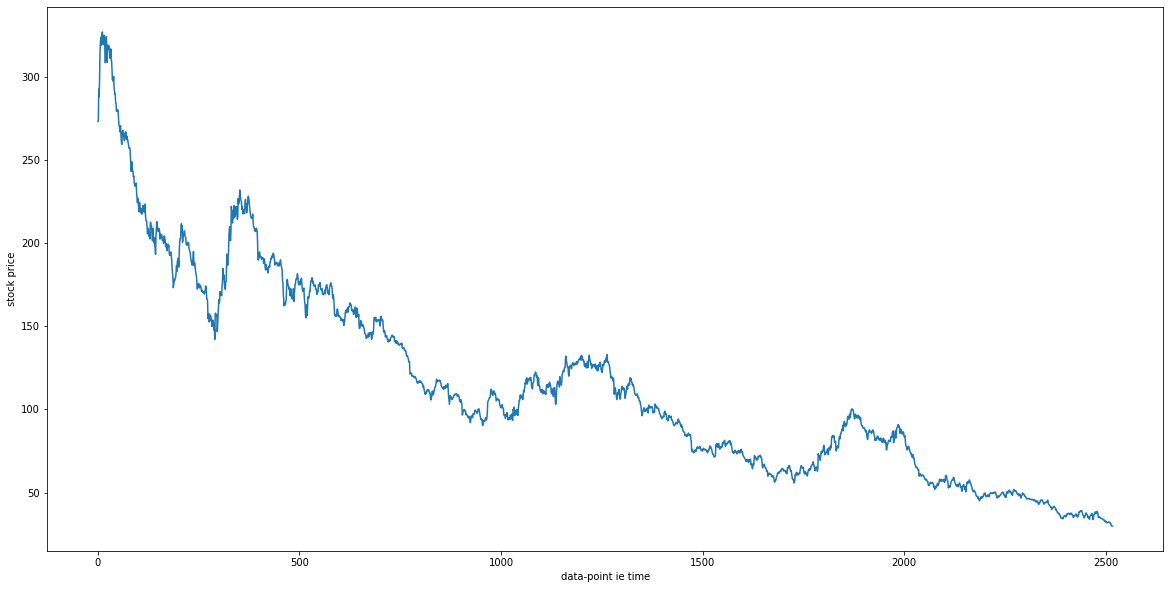

In [10]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

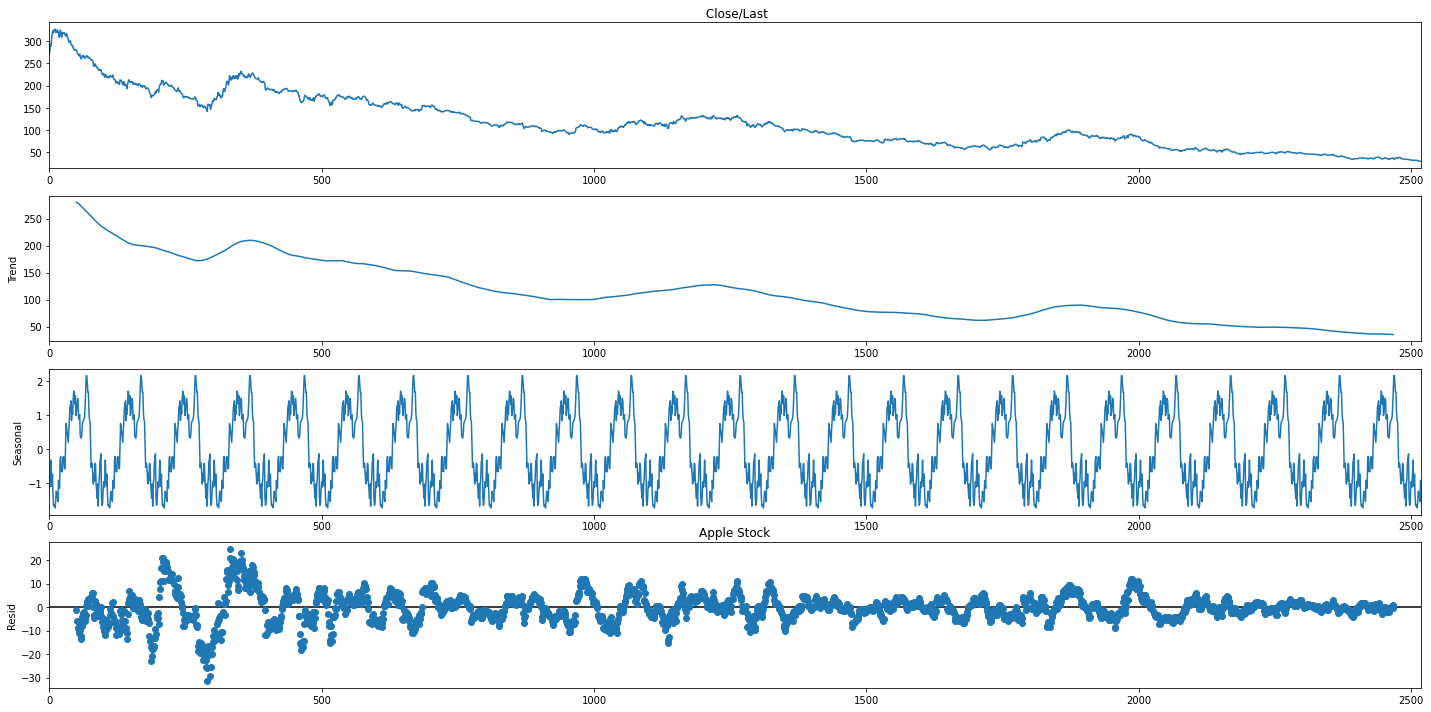

In [11]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [13]:
df1.shape

(2518,)

In [14]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[8.18942624e-01]
 [8.19480684e-01]
 [8.83812549e-01]
 ...
 [2.30693463e-04]
 [0.00000000e+00]
 [6.72575693e-05]]

 df1 present shape :  (2518, 1)


### splitting data (70/30)

In [16]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  1762
Test Size :  756


In [17]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (1762, 1)
Test Data Shape:  (756, 1)


### | windowing data set |

In [18]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [19]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1661, 100) (1661,)
(655, 100) (655,)


In [21]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [25]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
26/26 [==============================] - 11s 228ms/step - loss: 0.0182 - val_loss: 0.0122
Epoch 2/2
26/26 [==============================] - 5s 177ms/step - loss: 0.0018 - val_loss: 4.6774e-04


In [26]:
y_pred = scaler.inverse_transform(model.predict(X_test))

21/21 [==============================] - 2s 30ms/step


In [27]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [28]:
y_pred[:5]

array([[90.62578],
       [91.08913],
       [91.54712],
       [91.99913],
       [92.45397]], dtype=float32)

In [29]:
y_test[:5]

array([[94.4728],
       [94.1985],
       [95.3007],
       [97.3314],
       [95.0257]])

### evaluation

In [30]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  6.431164708206877


In [31]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.8812260045373553


### visualization + plotting

52/52 [==============================] - 2s 32ms/step


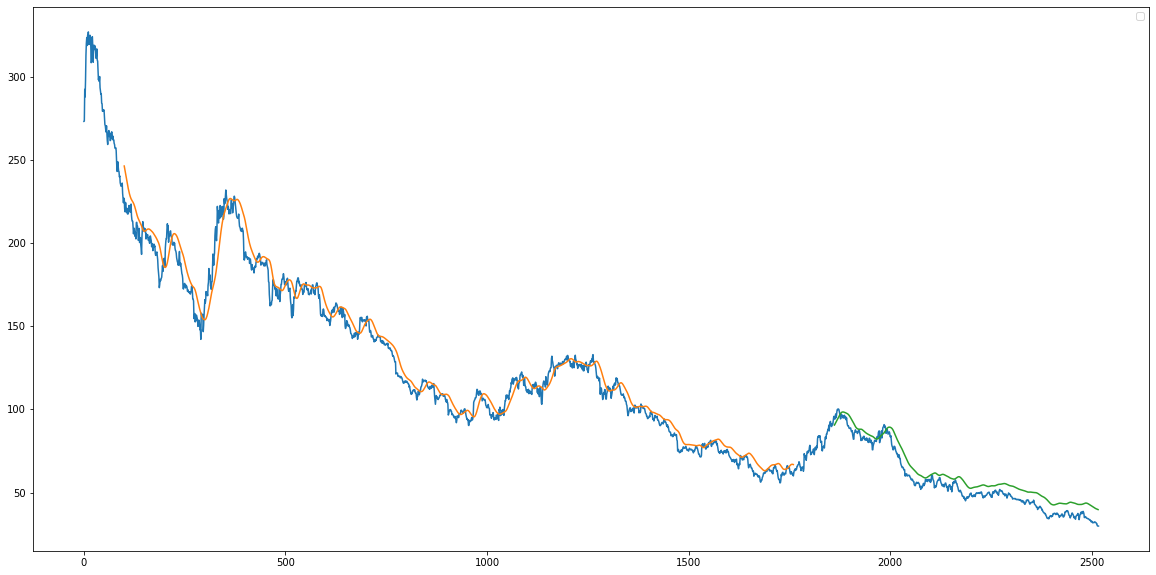

In [32]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [33]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
print(scaler.inverse_transform(lst_output))

[[39.50721884]
 [39.417802  ]
 [39.40227995]
 [39.47627776]
 [39.64242861]
 [39.89456666]
 [40.22136607]
 [40.60919023]
 [41.04412999]
 [41.51329647]
 [42.00555438]
 [42.5118023 ]
 [43.02497488]
 [43.53984455]
 [44.05275348]
 [44.56129891]
 [45.06404074]
 [45.56022237]
 [46.04958457]
 [46.53215948]
 [47.0081487 ]
 [47.47787239]
 [47.94163739]
 [48.39976053]
 [48.85252428]
 [49.30017568]
 [49.74291967]
 [50.18092019]
 [50.61432348]
 [51.04322923]]


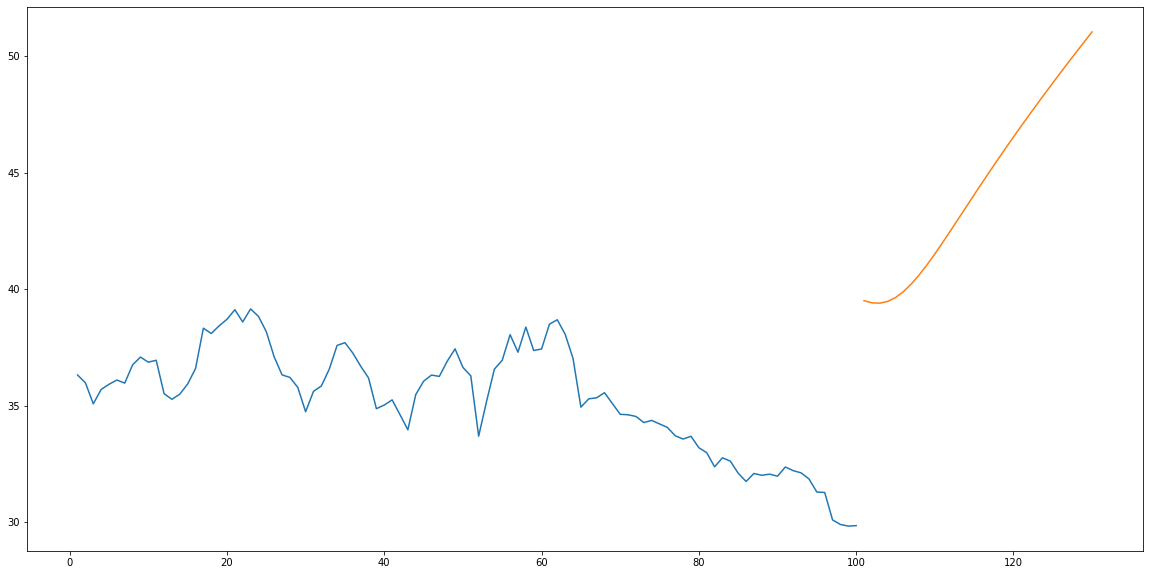

In [38]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

Dataset File 

https://www.kaggle.com/datasets/tarunpaparaju/apple-aapl-historical-stock-data